In [1]:
import tensorflow as tf
tf.version.VERSION

'2.8.0'

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers,Model
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [9]:
(train_ds, test_ds) = tfds.load('mnist',
                                split = ['train','test'],
                                shuffle_files=True,as_supervised=True)
def preprocess(image,label):
    image = tf.cast(image,tf.float32)
    image = image /255.0
    return image,image
train_ds=train_ds.map(preprocess)
train_ds =train_ds.cache()
train_ds = train_ds.batch(128)


In [10]:
class Sampler(layers.Layer):
    def call(self,inputs):
        z_mean,z_log_var  = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon  = tf.random.normal(shape = (batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampler()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

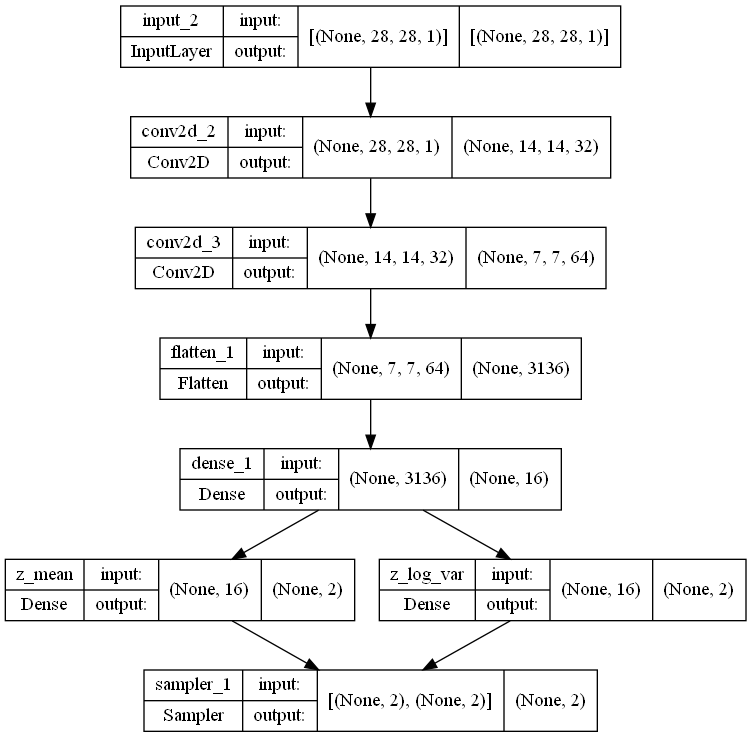

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(encoder, to_file='model_plot.png', show_shapes= True, show_layer_names=True)

In [13]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

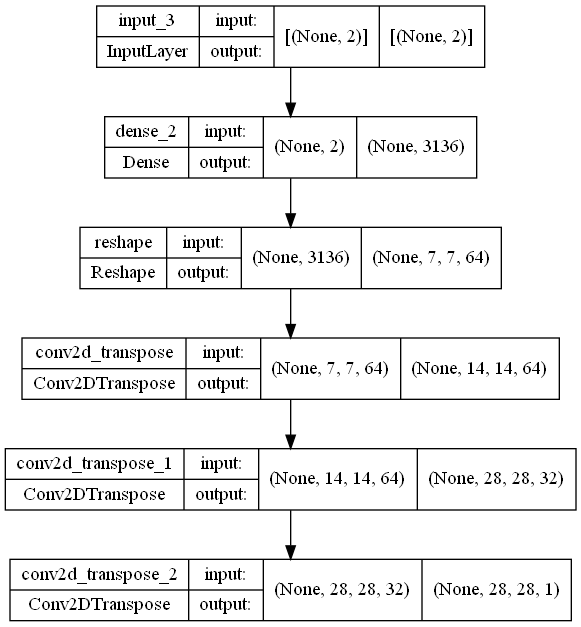

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(decoder, to_file='model_plot.png', show_shapes= True, show_layer_names=True)

In [15]:
class VAE(Model):
    def __init__(self,encoder,decoder):
        super(VAE,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.z_mean = None
        self.z_log_var = None


    def call(self,inputs):
        self.z_mean,self.z_log_var,z = self.encoder(inputs)
        outputs = self.decoder(z)
        return outputs
    
def bce_loss(y_true,y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return loss
def kl_loss(y_true,y_pred):
    kl_loss = -0.5 *tf.reduce_mean (
        1 + vae.z_log_var - tf.square(vae.z_mean) - tf.exp(vae.z_log_var))
    return kl_loss

def vae_loss(y_true,y_pred):
    bce = bce_loss(y_true,y_pred)
    kl = kl_loss(y_true,y_pred)
    kl_weight = 0.01
    loss = bce + kl_weight*kl
    return loss

In [16]:
vae = VAE(encoder,decoder)
vae.compile(
    loss = [vae_loss],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[kl_loss,vae_loss])
vae.fit(train_ds, epochs = 10)

Epoch 1/10
469/469 [==============================] - 38s 80ms/step - loss: 0.2755 - kl_loss: 0.4536 - vae_loss: 0.2755
Epoch 2/10
469/469 [==============================] - 35s 75ms/step - loss: 0.2435 - kl_loss: 0.8607 - vae_loss: 0.2435
Epoch 3/10
469/469 [==============================] - 35s 75ms/step - loss: 0.2270 - kl_loss: 1.5179 - vae_loss: 0.2270
Epoch 4/10
469/469 [==============================] - 36s 76ms/step - loss: 0.2227 - kl_loss: 1.6714 - vae_loss: 0.2227
Epoch 5/10
469/469 [==============================] - 35s 75ms/step - loss: 0.2203 - kl_loss: 1.7700 - vae_loss: 0.2203
Epoch 6/10
469/469 [==============================] - 36s 76ms/step - loss: 0.2189 - kl_loss: 1.8262 - vae_loss: 0.2189
Epoch 7/10
469/469 [==============================] - 38s 80ms/step - loss: 0.2179 - kl_loss: 1.8624 - vae_loss: 0.2179
Epoch 8/10
469/469 [==============================] - 37s 78ms/step - loss: 0.2172 - kl_loss: 1.8915 - vae_loss: 0.2172
Epoch 9/10
469/469 [====================

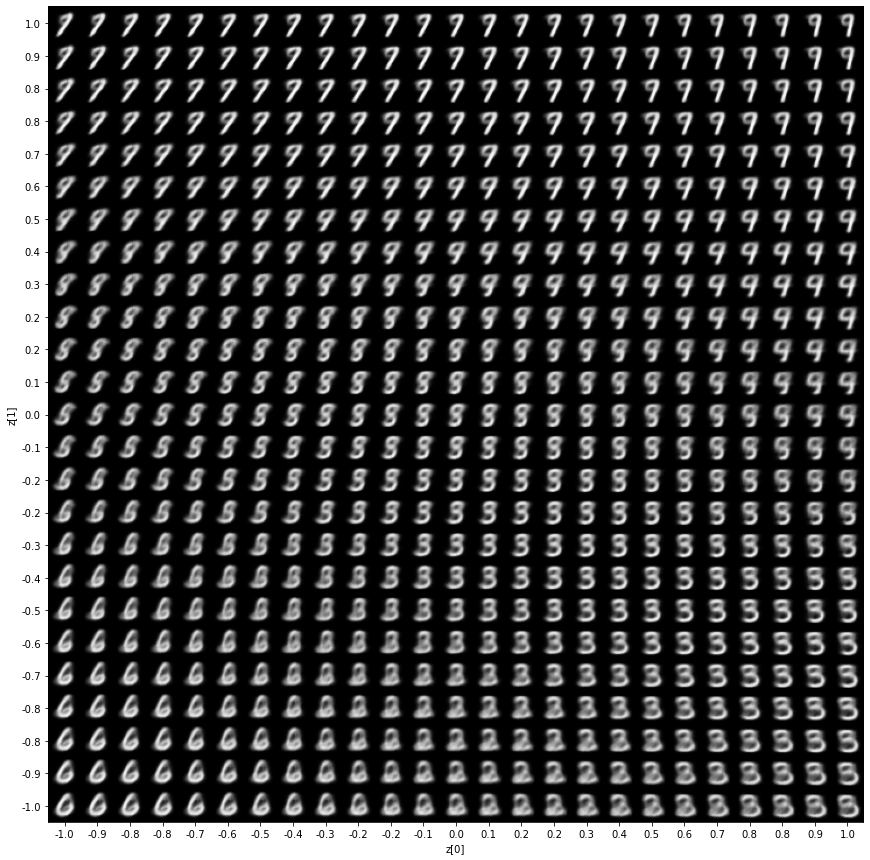

In [17]:
def plot_latent_space(vae, n=25, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
plot_latent_space(vae)

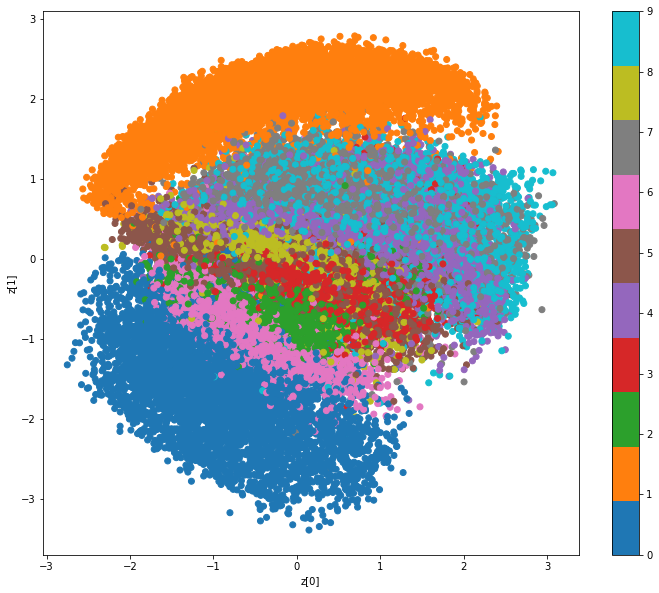

In [18]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels ,cmap =  'tab10')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)